# Results of Global search 
## Synthetic 3 Layer case

In [12]:
%matplotlib widget

In [79]:
# Import libraries
#import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import pandas as pd
import pygimli as pg
import copy 
import matplotlib

import sys
sys.path.insert(1, '../../src')

from EM1D import EMf_3Lay_HVP

### Load Model

In [14]:
# Import the conductivities and thicknesses used to create the LU table

conds = np.load('../data/conds.npy')
thick = np.load('../data/thicks.npy')

survey = np.load('../data/survey_3Lay.npy', allow_pickle=True).item()

offsets = survey['offsets']
height = survey['height']
freq = survey['freq']
lambd = survey['lambd']
filt = survey['filt']

model_true = np.load('data/model_synth_3Lay_B1.npy')
model_est_FS = np.load('results/model_3Lay_B1_GS.npy')

data_true =  np.load('data/data_synth_3Lay_B1.npy')

npos = len(model_true)
nlayer = 3

depths_true = np.zeros((npos, nlayer))
sigmas_true = np.zeros((npos, nlayer))

depths_true[:,1] = model_true[:,3]
depths_true[:,2] = model_true[:,3] + model_true[:,4]
sigmas_true[:,:] = model_true[:,:3]

## See Error Space

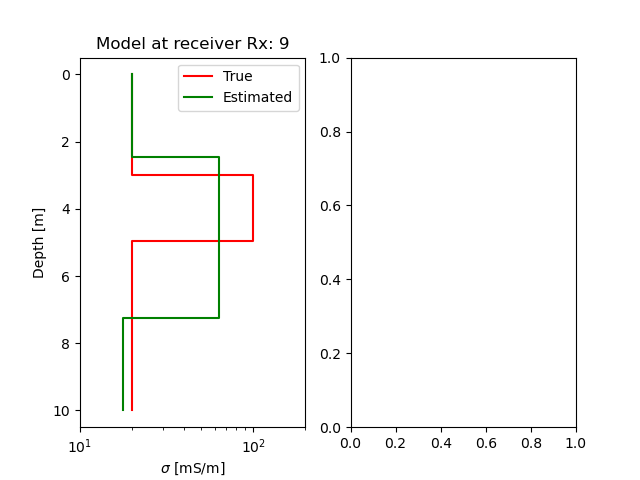

In [15]:
pos=9
depthmax=10

depth_true = np.array([0, model_true[pos,3], model_true[pos,3]+model_true[pos,4],depthmax])
depth_est = np.array([0, model_est_FS[pos,3], model_true[pos,3]+model_est_FS[pos,4], depthmax])

sigma_true = np.hstack([model_true[pos,:3], model_true[pos,2]])
sigma_est = np.hstack([model_est_FS[pos,:3], model_est_FS[pos,2]])

fig, ax = plt.subplots(1,2)

ax[0].step(sigma_true*1000, depth_true, 'r', label = 'True')
ax[0].step(sigma_est*1000, depth_est, 'g', label='Estimated')
ax[0].invert_yaxis()
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('$\sigma$ [mS/m]')
ax[0].set_title('Model at receiver Rx: ' +str(pos))
ax[0].set_xlim([10,200])
ax[0].set_xscale('log')
ax[0].legend()

In [51]:
def ErrorSpace3Lay(m_est_pos, data_true_pos, conds, thicks, max_err=0.1):
    # Evaluate only conductivity and thickness of middle layer
    
    err = []
    models_below_err = []
    
    for c2 in conds:
        for t1 in thicks: 
            for t2 in thicks:
                m = [m_est_pos[0], c2, m_est_pos[2], t1, t2]
                data_est_pos = EMf_3Lay_HVP(lambd = lambd,
                                            sigma1=m_est_pos[0],
                                            sigma2=c2,
                                            sigma3=m_est_pos[2],
                                            h1=t1,
                                            h2=t2, 
                                            height=height,
                                            offsets=offsets,
                                            freq=freq,
                                            filt=filt) 
                diff = np.abs((data_true_pos - data_est_pos)/data_true_pos)
                merr = np.sum(diff)/len(data_true_pos)

                if merr < max_err:
                    err.append(merr)       
                    models_below_err.append(m)
    
    return models_below_err, err

In [52]:
m_est_pos = model_est_FS[pos]
data_true_pos = data_true[pos]

In [74]:
models_below_err, error = ErrorSpace3Lay(m_est_pos, data_true_pos, conds, thick, max_err=0.055)

In [75]:
models_below_err = np.array(models_below_err)
error = np.array(error)

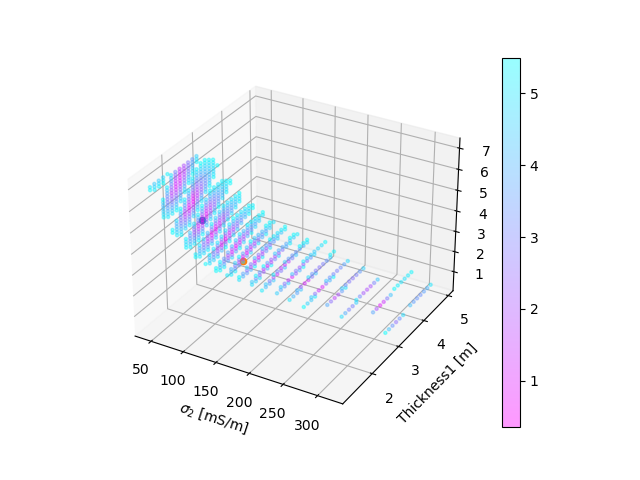

In [76]:
conds2_b2 = models_below_err[:,1]
thicks_b1 = models_below_err[:,3]
thicks_b2 = models_below_err[:,4]

fig = plt.figure()

ax3D = fig.add_subplot(111, projection='3d')
p = ax3D.scatter(((conds2_b2)*1000), thicks_b1, thicks_b2,
                 s=5, c=error*100, marker='o', cmap='cool_r', alpha=0.4)
ax3D.scatter(model_est_FS[pos,1]*1000, model_est_FS[pos,3], model_est_FS[pos,4])
ax3D.scatter(model_true[pos,1]*1000, model_true[pos,3], model_true[pos,4])
ax3D.set_xlabel('$\sigma_2$ [mS/m]')
ax3D.set_ylabel('Thickness1 [m]')
ax3D.set_zlabel('Thickness 2 [m]')
clb = fig.colorbar(p, ax=ax3D)

ValueError: x and y arrays must consist of at least 3 unique points

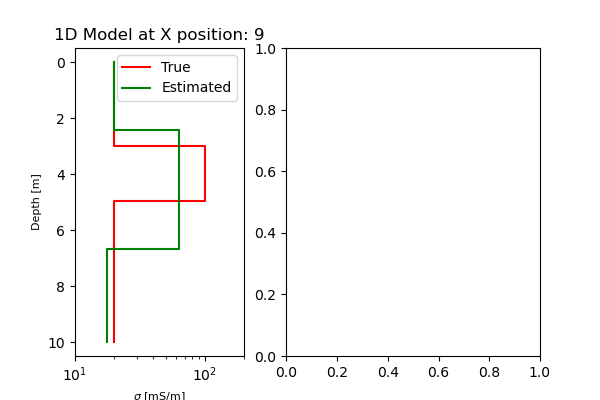

In [56]:
# Error space using Q + IP
import matplotlib.tri as tri

def PlotErrorSpace(model, model_est, pos, err, models_err, depthmax=10):
    
    # Arrays to plot
    depth_true = np.array([0, model[pos,3], model[pos,3]+model[pos,4], depthmax])
    depth_est = np.array([0, model_est[pos,3], model_est[pos,3]+model_est[pos,4], depthmax])

    sigma_true = np.hstack([model[pos,:3], model[pos,2]])
    sigma_est = np.hstack([model_est[pos,:3], model_est[pos,2]])
       
    fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax[0].step(sigma_true*1000, depth_true, 'r', label = 'True')
    ax[0].step(sigma_est*1000, depth_est, 'g', label='Estimated')
    ax[0].invert_yaxis()
    ax[0].set_ylabel('Depth [m]', fontsize=8)
    ax[0].set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax[0].set_title('1D Model at X position: ' +str(pos))
    ax[0].set_xscale('log')
    ax[0].set_xlim([10,200])
    ax[0].legend()

    x = models_err[:,0] # thickness of 2 layer
    y = models_err[:,2] # thickness of 1 layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    # from scipy.interpolate import griddata
    # zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

    ax[1].contour(xi, yi, zi*100, levels=14, linewidths=0.5, colors='k')
    cntr1 = ax[1].contourf(xi, yi, zi*100, levels=14, cmap="RdBu_r")
    ax[1].plot(x, y, '.k', ms=1)
    #ax[1].set(xlim=(0.05,0.1), ylim=(2,3))
    ax[1].scatter(model_est[pos,0], model_est[pos,2],
                 marker ='^', c='y', label='Estimated model')
    #ax1.scatter( np.log10((model_cm_pos[1])*1000), model_cm_pos[2],
    #             marker ='^', c='k', label='Closest')
    ax[1].set_xlabel('$\sigma_1$ [mS/m]', fontsize=8)
    ax[1].set_ylabel('$\sigma_2$ [mS/m]', fontsize=8)
    #ax[1].set_xscale('log')
    ax[1].legend()
    ax[1].tick_params(axis='both',labelsize=9)
    ax[0].tick_params(axis='both',labelsize=9)
    clb = fig.colorbar(cntr1, ax=ax[1])
    clb.ax.set_title('RMS Error %')
    clb.ax.tick_params(labelsize=9)
    
    #xticks = np.arange(0.050, 0.1, 10)
    #xlabels = xticks*1000
    #ax[1].set_xticks(xticks, labels=xlabels)

PlotErrorSpace(model_true, model_est_FS, pos, error, models_below_err)
plt.tight_layout()
plt.show()

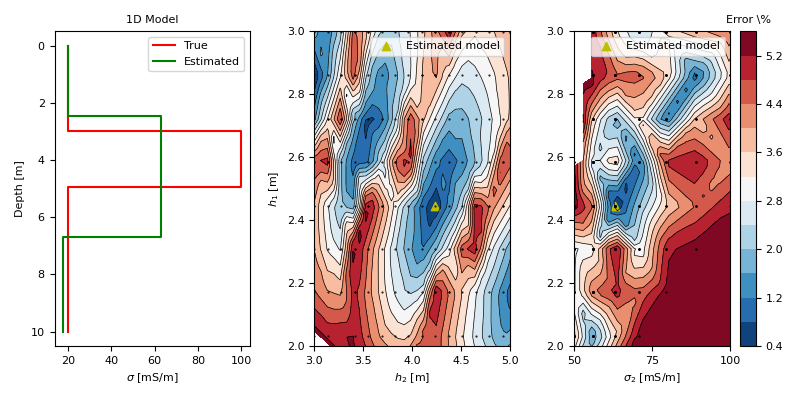

In [80]:
def PlotErrorSpace(model, model_est, pos, err, models_err, depthmax=10):
    
    # Arrays to plot
    depth_true = np.array([0, model[pos,3], model[pos,3]+model[pos,4], depthmax])
    depth_est = np.array([0, model_est[pos,3], model_est[pos,3]+model_est[pos,4], depthmax])

    sigma_true = np.hstack([model[pos,:3], model[pos,2]])
    sigma_est = np.hstack([model_est[pos,:3], model_est[pos,2]])
       
    fig = plt.figure(figsize=(8,4))
    
    ax0 = fig.add_subplot(1,3,1)
    
    ax0.step(sigma_true*1000, depth_true, 'r', label = 'True')
    ax0.step(sigma_est*1000, depth_est, 'g', label='Estimated')
    ax0.invert_yaxis()
    ax0.set_ylabel('Depth [m]', fontsize=8)
    ax0.set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax0.set_title('1D Model', fontsize=8) # at X position: ' +str(pos), fontsize=8)
    #ax[0].set_xscale('log')
    #ax[0].set_xlim([10,200])
    ax0.legend(fontsize=8)

    x = models_err[:,4] # thickness of 2 layer
    y = models_err[:,3] # thickness of 1 layer
    z = err
    
    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    # from scipy.interpolate import griddata
    # zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')
    
    ax1 = fig.add_subplot(1,3,2)
    
    my_cmap = copy.copy(matplotlib.cm.get_cmap("RdBu_r")) # copy the default cmap
    my_cmap.set_bad('w')

    ax1.contour(xi, yi, zi*100, levels=14, linewidths=0.5, colors='k', )
    cntr1 = ax1.contourf(xi, yi, zi*100, levels=14, cmap=my_cmap)
    ax1.plot(x, y, '.k', ms=1)
    ax1.set(xlim=(3,5), ylim=(2,3))
    ax1.scatter(model_est[pos,4], model_est[pos,3],
                 marker ='^', c='y', label='Estimated model')
    #ax1.scatter( np.log10((model_cm_pos[1])*1000), model_cm_pos[2],
    #             marker ='^', c='k', label='Closest')
    ax1.set_xlabel('$h_2$ [m]', fontsize=8)
    ax1.set_ylabel('$h_1$ [m]', fontsize=8)
    #ax[1].set_xscale('log')
    ax1.legend(fontsize=8)
    ax1.tick_params(axis='both',labelsize=8)
    #xticks = np.linspace(3, 5, 3)
    #xlabels = [3,4,5]
    
    
    x = models_err[:,1]  # resistivity of second
    y = models_err[:,3] # thickness of 1 layer
   
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    # from scipy.interpolate import griddata
    # zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')
    
    ax2 = fig.add_subplot(1,3,3, sharey=ax1)

    ax2.contour(xi, yi, zi*100, levels=14, linewidths=0.5, colors='k')
    cntr1 = ax2.contourf(xi, yi, zi*100, levels=14, cmap=my_cmap)
    ax2.plot(x, y, '.k', ms=1)
    ax2.set(xlim=(0.05,0.1), ylim=(2,3))
    ax2.scatter(model_est[pos,1], model_est[pos,3],
                 marker ='^', c='y', label='Estimated model')
    #ax1.scatter( np.log10((model_cm_pos[1])*1000), model_cm_pos[2],
    #             marker ='^', c='k', label='Closest')
    ax2.set_xlabel('$\sigma_2$ [mS/m]', fontsize=8)
    #ax[2].set_ylabel('Thickness $h_1$ [m]', fontsize=8)
    #ax2.set_xscale('log')
    ax2.legend(fontsize=8)
    xticks = np.linspace(0.050, 0.1, 3)
    xlabels = [50, 75, 100]
    ax2.set_xticks(xticks, labels=xlabels,)
    ax2.tick_params(axis='both',labelsize=8)
    ax0.tick_params(axis='both',labelsize=8)
    clb = fig.colorbar(cntr1, ax=ax2)
    clb.ax.set_title('Error \%', fontsize=8)
    clb.ax.tick_params(labelsize=8)
    
PlotErrorSpace(model_true, model_est_FS, pos, error, models_below_err)
plt.tight_layout()
plt.show()

In [81]:
plt.savefig('figures/ErrorSpace_3Lay.eps', format='eps')

18/01/24 - 14:48:16 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Models below 5%

In [ ]:
models_below_err_5, error_5 = ErrorSpace3Lay(m_est_pos, data_true_pos, conds, thick, max_err=0.05)

In [ ]:
models_below_err_5 = np.array(models_below_err_5)
error_5 = np.array(error_5)

In [ ]:
fig, ax = plt.subplots()

for m in range(len(models_below_err_5)):
    # Arrays to plot
    depth_est_b = np.array([0, models_below_err_5[m,3], models_below_err_5[m,3]+models_below_err_5[m,4], depthmax])
    sigma_est_b = np.hstack([models_below_err_5[m,:3], models_below_err_5[m,2]])

    ax.step(sigma_est_b*1000, depth_est_b, 'c', alpha=0.5, linewidth=0.5)
ax.step(sigma_true*1000, depth_true, 'r', label = 'True model', linewidth=2)
ax.step(sigma_est*1000, depth_est, 'g', label='Estimated', linewidth=2)
ax.invert_yaxis()
ax.set_ylabel('Depth [m]')
ax.set_xlabel('$\sigma$ [mS/m]')
ax.set_xscale('log')
#ax.set_xlim([15, 500])
ax.legend()
ax.set_title('1D models below 5% Relative Error')
               
plt.show()